In [1]:
import os
import pandas as pd
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt

from PIL import Image
import cv2
import imageio
import random
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score

In [2]:
directory = '/content/drive/MyDrive/Omdena_lung_cancer/lung_cancer_data/The IQ-OTHNCCD lung cancer dataset'
categories =['Benign cases', 'Malignant cases', 'Normal cases']

## Check the access to data

Benign cases


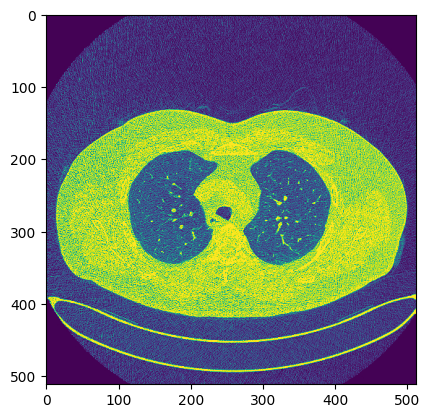

Malignant cases


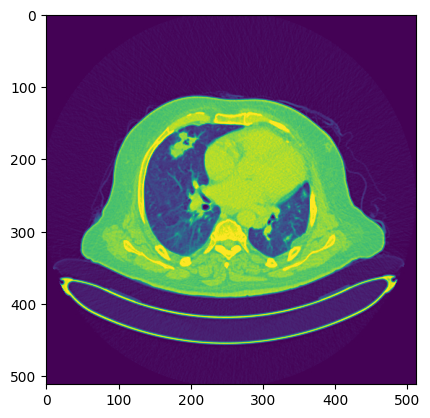

Normal cases


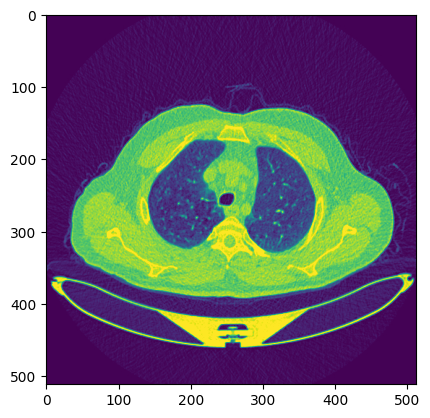

In [3]:
for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        print(i)
        img = cv2.imread(filepath, 0)
        plt.imshow(img)
        plt.show()
        break

## Preparing data

In [4]:
data = []
img_size = 256

for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath, 0)
        # preprocess here
        img = cv2.resize(img, (img_size, img_size))
        data.append([img, class_num])

random.shuffle(data)

In [5]:
X, y = [], []
for feature, label in data:
    X.append(feature)
    y.append(label)

print('X length:', len(X))
print('y counts:', Counter(y))

X length: 1097
y counts: Counter({1: 561, 2: 416, 0: 120})


note that the dataset is inbalanced

In [6]:
# normalize
X = np.array(X).reshape(-1, img_size, img_size, 1)
X = X / 255.0
y = np.array(y)

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=42, test_size=0.3)

In [8]:
print(len(X_train), X_train.shape)
print(len(X_valid), X_valid.shape)

767 (767, 256, 256, 1)
330 (330, 256, 256, 1)


## Apply SMOTE to oversample the data

In [9]:
from imblearn.over_sampling import SMOTE

In [10]:
print(len(X_train), X_train.shape)

X_train = X_train.reshape(X_train.shape[0], img_size*img_size*1)

print(len(X_train), X_train.shape)

767 (767, 256, 256, 1)
767 (767, 65536)


In [11]:
print('Before SMOTE:', Counter(y_train))
smote = SMOTE()
X_train_sampled, y_train_sampled = smote.fit_resample(X_train, y_train)
print('After SMOTE:', Counter(y_train_sampled))

Before SMOTE: Counter({1: 384, 2: 294, 0: 89})
After SMOTE: Counter({2: 384, 0: 384, 1: 384})


In [12]:
X_train = X_train.reshape(X_train.shape[0], img_size, img_size, 1)
X_train_sampled = X_train_sampled.reshape(X_train_sampled.shape[0], img_size, img_size, 1)

print(len(X_train), X_train.shape)
print(len(X_train_sampled), X_train_sampled.shape)

767 (767, 256, 256, 1)
1152 (1152, 256, 256, 1)


## Basic CNN model

In [13]:
import tensorflow as tf
tf.random.set_seed(42)
import keras

In [38]:
from keras.models import Model
from keras.layers import Input, Dropout, Dense, Flatten, MaxPooling2D, Conv2D
from keras.layers import GlobalAveragePooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.metrics import SparseCategoricalCrossentropy

In [33]:
class BasicCNN(tf.keras.Model):
  def __init__(self):
    super(BasicCNN, self).__init__()
    self.act = tf.keras.layers.Activation('relu')
    self.conv1 = tf.keras.layers.Conv2D(64, 3, padding='same')
    self.max_pool1 = tf.keras.layers.MaxPool2D(pool_size=(2,2))
    self.conv2 = tf.keras.layers.Conv2D(64, 3, padding='same')
    self.max_pool2 = tf.keras.layers.MaxPool2D(pool_size=(2,2))
    self.conv3 = tf.keras.layers.Conv2D(128, 3, padding='same')
    self.max_pool3 = tf.keras.layers.MaxPool2D(pool_size=(2,2))
    self.flatten = tf.keras.layers.Flatten()
    self.dense1 = tf.keras.layers.Dense(128)
    self.dense2 = tf.keras.layers.Dense(3, activation='softmax')
    self.dropout = tf.keras.layers.Dropout(0.4)


  def call(self, inputs):
    x = self.conv1(inputs)
    x = self.act(x)
    x = self.max_pool1(x)
    x = self.conv2(x)
    x = self.act(x)
    x = self.max_pool2(x)
    x = self.conv3(x)
    x = self.act(x)
    x = self.max_pool3(x)
    x = self.flatten(x)
    x = self.dense1(x)
    x = self.dropout(x)
    x = self.dense2(x)
    return x

In [42]:
model_1 = BasicCNN()
model_1.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [44]:
r = model_1.fit(X_train_sampled, y_train_sampled, batch_size=8, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
144/144 [==============================] - 4s 28ms/step - loss: 0.0299 - accuracy: 0.9896 - val_loss: 0.1792 - val_accuracy: 0.9758
Epoch 2/10
144/144 [==============================] - 4s 26ms/step - loss: 0.0514 - accuracy: 0.9844 - val_loss: 0.0489 - val_accuracy: 0.9758
Epoch 3/10
144/144 [==============================] - 4s 26ms/step - loss: 0.0032 - accuracy: 0.9991 - val_loss: 0.1373 - val_accuracy: 0.9758
Epoch 4/10
144/144 [==============================] - 4s 25ms/step - loss: 0.0230 - accuracy: 0.9974 - val_loss: 0.0883 - val_accuracy: 0.9939
Epoch 5/10
144/144 [==============================] - 4s 26ms/step - loss: 0.0277 - accuracy: 0.9896 - val_loss: 0.0690 - val_accuracy: 0.9848
Epoch 6/10
144/144 [==============================] - 4s 26ms/step - loss: 0.0287 - accuracy: 0.9922 - val_loss: 0.0611 - val_accuracy: 0.9848
Epoch 7/10
144/144 [==============================] - 4s 25ms/step - loss: 0.0078 - accuracy: 0.9991 - val_loss: 0.0752 - val_accuracy: 0.9909

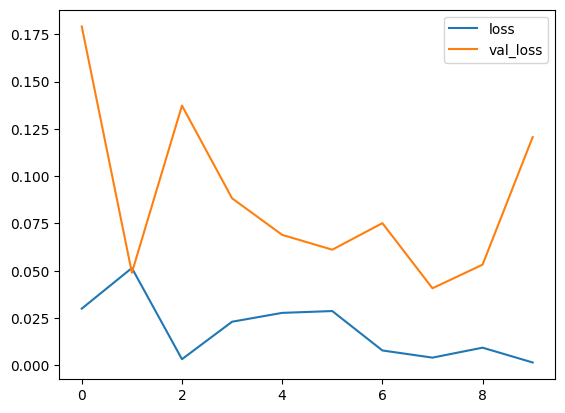

In [45]:
# plot loss per iteration
plt.plot(r.history["loss"], label="loss")
plt.plot(r.history["val_loss"], label="val_loss")
plt.legend()

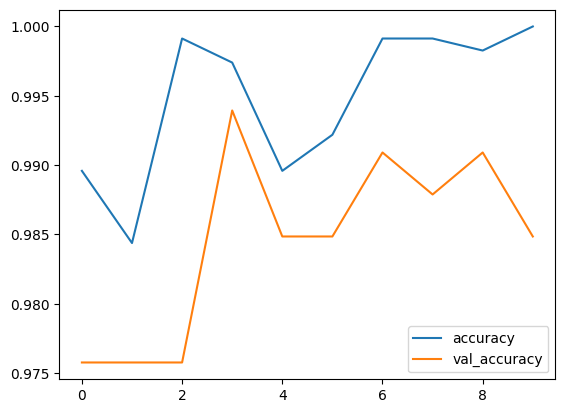

In [46]:
plt.plot(r.history["accuracy"], label="accuracy")
plt.plot(r.history["val_accuracy"], label="val_accuracy")
plt.legend()

## Densenet121 model

In [20]:
# Densenet takes RGB images as input
X_train_rgb = tf.image.grayscale_to_rgb(tf.convert_to_tensor(X_train_sampled))
X_valid_rgb = tf.image.grayscale_to_rgb(tf.convert_to_tensor(X_valid))

print(len(X_train_sampled), X_train_sampled.shape)
print(len(X_train_rgb), X_train_rgb.shape)

1152 (1152, 256, 256, 1)
1152 (1152, 256, 256, 3)


In [21]:
from keras.applications import DenseNet121
from keras.applications.densenet import preprocess_input

In [47]:
model_d=DenseNet121(weights='imagenet',include_top=False, input_shape=[img_size, img_size, 3])

x=model_d.output

x= GlobalAveragePooling2D()(x)
x= BatchNormalization()(x)
x= Dropout(0.4)(x)
x= Dense(1024,activation='relu')(x)
x= Dense(512,activation='relu')(x)
#x= BatchNormalization()(x)
x= Dropout(0.4)(x)

preds=Dense(3,activation='softmax')(x)

In [48]:
densenet = Model(inputs=model_d.input, outputs=preds)
for layer in densenet.layers[:-8]:
    layer.trainable=False

for layer in densenet.layers[-8:]:
    layer.trainable=True

In [49]:
densenet.compile(
    optimizer='Adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])
densenet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 262, 262, 3)  0          ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 128, 128, 64  9408        ['zero_padding2d_2[0][0]']       
                                )                                                           

In [50]:
r = densenet.fit(X_train_rgb, y_train_sampled, batch_size=8, epochs=10, validation_data=(X_valid_rgb, y_valid))

Epoch 1/10
144/144 [==============================] - 19s 73ms/step - loss: 0.6371 - accuracy: 0.7856 - val_loss: 0.5323 - val_accuracy: 0.7818
Epoch 2/10
144/144 [==============================] - 7s 47ms/step - loss: 0.2675 - accuracy: 0.8976 - val_loss: 0.1274 - val_accuracy: 0.9545
Epoch 3/10
144/144 [==============================] - 8s 58ms/step - loss: 0.2159 - accuracy: 0.9245 - val_loss: 0.1386 - val_accuracy: 0.9545
Epoch 4/10
144/144 [==============================] - 7s 49ms/step - loss: 0.1424 - accuracy: 0.9531 - val_loss: 0.2405 - val_accuracy: 0.9242
Epoch 5/10
144/144 [==============================] - 7s 51ms/step - loss: 0.1557 - accuracy: 0.9479 - val_loss: 0.0770 - val_accuracy: 0.9636
Epoch 6/10
144/144 [==============================] - 8s 55ms/step - loss: 0.0914 - accuracy: 0.9670 - val_loss: 0.0862 - val_accuracy: 0.9758
Epoch 7/10
144/144 [==============================] - 8s 58ms/step - loss: 0.1126 - accuracy: 0.9635 - val_loss: 0.1432 - val_accuracy: 0.957

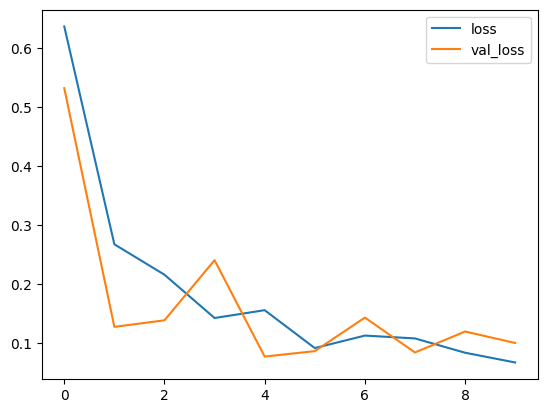

In [51]:
# plot loss per iteration
plt.plot(r.history["loss"], label="loss")
plt.plot(r.history["val_loss"], label="val_loss")
plt.legend()

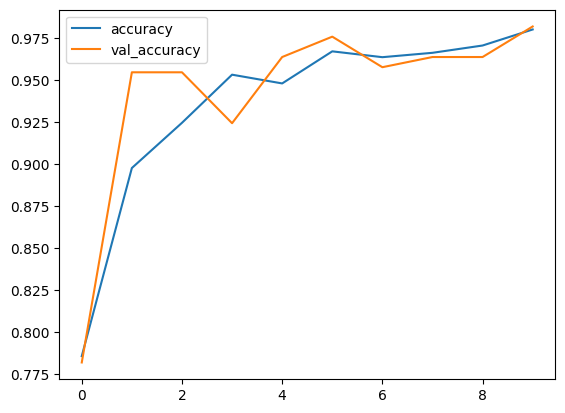

In [52]:
plt.plot(r.history["accuracy"], label="accuracy")
plt.plot(r.history["val_accuracy"], label="val_accuracy")
plt.legend()